In [1]:

import numpy as np
import pandas as pd
import config as cfg

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

def rename_model_names(df):
    model_name_mapping = {
        'cox': 'CoxPH',
        'rsf': 'RSF',
        'dsm': 'DSM',
        'deepsurv': 'DeepSurv',
        'deephit': 'DeepHit',
        'dcsurvival': 'DCSurvival',
        'mtlr': 'MTLR',
        'mensa': 'MENSA (Our)',
    }
    df['ModelName'] = df['ModelName'].replace(model_name_mapping)
    return df

filename = f"{cfg.RESULTS_DIR}/synthetic_se_aug_14.csv"
df = pd.read_csv(filename)
df = df.round(3)

df = df.loc[df['ModelName'] != "DGP"]
df = df.loc[df['ModelName'] != "mensa"]

df = rename_model_names(df)

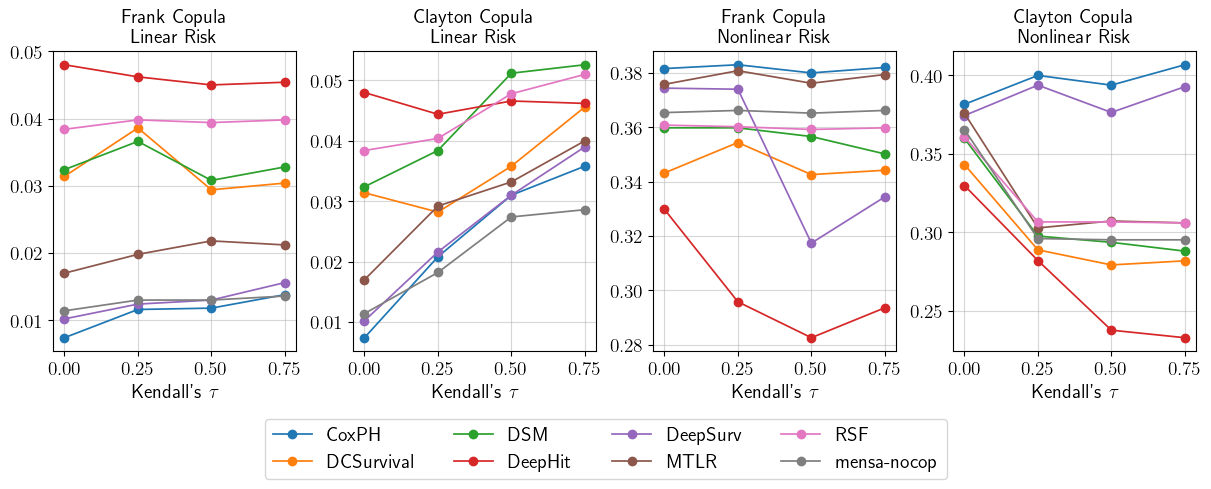

In [11]:
grouped_df = df.groupby(['ModelName', 'KTau', 'Linear', 'Copula'], as_index=False)['L1'].mean()
grouped_df = grouped_df.fillna(0.40)  # for cox

# Create a 1x4 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)

# Define the specific order of copulas and linearity values
copula_linear_pairs = [
    ('frank', True),      # Frank Copula / Linear Risk
    ('clayton', True),    # Clayton Copula / Linear Risk
    ('frank', False),     # Frank Copula / Nonlinear Risk
    ('clayton', False)    # Clayton Copula / Nonlinear Risk
]

# Store handles and labels for the legend
handles = []
labels = []

# Iterate through each specified combination in the required order
for idx, (copula, linear) in enumerate(copula_linear_pairs):
    # Filter the data for the current copula and linearity
    plot_data = grouped_df[(grouped_df['Copula'] == copula) & (grouped_df['Linear'] == linear)]
    
    # Select the appropriate subplot
    ax = axs[idx]
    
    # Iterate through each unique model name to create separate plots
    for model in plot_data['ModelName'].unique():
        model_data = plot_data[plot_data['ModelName'] == model]
        
        linestyle = "dashed" if model_data['ModelName'].iloc[0] == "MENSA2" else "solid"
        line, = ax.plot(model_data['KTau'], model_data['L1'], marker='o', label=model,
                        linewidth=1.25, markersize=6, linestyle=linestyle)
        
        # Collect handles and labels for the legend if not already included
        if model not in labels:
            handles.append(line)
            labels.append(model)
    
    # Set the y-axis and x-axis labels, title, and grid
    ax.set_xlabel(r"Kendall's $\tau$")
    ax.set_title(f"{copula.capitalize()} Copula\n" + ("Linear Risk" if linear else "Nonlinear Risk"))
    ax.grid(True, alpha=0.5)
    ax.set_xticks([0, 0.25, 0.5, 0.75])

# Create a shared legend below the plot
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4)

# Save the figure
fig.savefig(f"{cfg.RESULTS_DIR}/survival_l1.pdf", format='pdf', bbox_inches='tight')